In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import scipy.stats as scs
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV, KFold, GridSearchCV, cross_val_score
import xgboost as xgb

In [ ]:
# Data from: https://www.kaggle.com/jiashenliu/515k-hotel-reviews-data-in-europe

In [ ]:
data = pd.read_csv('Hotel_Reviews.csv')

# remove rows with no reviews
data = data[(data['Negative_Review'] != 'No Negative') | (data['Positive_Review'] != 'No Positive')]
data.reset_index(drop=True, inplace=True)

In [ ]:
data.info()

In [ ]:
#how many unqiue in each column
for i in data.columns:
    print(i, len(data[i].unique()))

In [ ]:
#Drop unwanted columns
data.drop(['Hotel_Name','Hotel_Address','Review_Date','days_since_review', 'lat', 'lng'],  axis=1, inplace=True)
data['Average_Score'].astype(float)

In [ ]:
#correcting tags from 55,000 to a few - started as a list of strings that looked like lists of strings
tags = data.Tags

import ast
new_tags = []
for i in tags:
    new_tags.append(ast.literal_eval(i))

In [ ]:
# check most common tags
from collections import Counter
list_for_counting = []
for i in new_tags:
    for t in i:
        list_for_counting.append(t)
    
c = Counter(list_for_counting)
c.most_common(20)      

In [ ]:
#feature engineering tags to reduce columns
for index, i in enumerate(new_tags):
    for idx, t in enumerate(i):
        if t not in ['Stayed 1-2 nights','Stayed 3-4 nights', 'Stayed 5+ nights', 'Fancy', 'Budget', 'Medium', 'High', ' Business trip ', ' Solo traveler ', ' Leisure trip ', ' Couple ', ' Group ', ' Family with young children ', ' Family with older children ']:
            if t in [' Stayed 1 night ',' Stayed 2 nights ']:
                new_tags[index][idx] = 'Stayed 1-2 nights'
            if t in [' Stayed 3 nights ',' Stayed 4 nights ']:
                new_tags[index][idx] = 'Stayed 3-4 nights'
            if t in [' Stayed 5 nights ',' Stayed 6 nights ', ' Stayed 7 nights ', ' Stayed 8 nights ', ' Stayed 9 nights ', ' Stayed 10 nights ',  ' Stayed 11 nights ',
                 ' Stayed 12 nights ', ' Stayed 13 nights ', ' Stayed 14 nights ', ' Stayed 15 nights ', ' Stayed 16 nights ', ' Stayed 17 nights ',' Stayed 18 nights ', ' Stayed 19 nights ', ' Stayed 20 nights ',
                 ' Stayed 21 nights ', ' Stayed 22 nights ', ' Stayed 23 nights ', ' Stayed 24 nights ', ' Stayed 25 nights ', ' Stayed 26 nights ',
                 ' Stayed 27 nights ', ' Stayed 28 nights ', ' Stayed 29 nights ', ' Stayed 30 nights ', ' Stayed 31 nights ',]:
                new_tags[index][idx] = 'Stayed 5+ nights'
            if 'Luxury' in t or 'VIP' in t or 'Executive' in t or 'Ambassador' in t or 'Royal' in t or 'Penthouse' in t or 'Suite' in t or 'Duplex' in t or 'Presidential' in t or 'Apartment' in t or 'Apartement' in t:
                new_tags[index][idx] = 'Fancy'
            if 'Superior' in t or 'Premium' in t or 'Prestige' in t or 'Premiere' in t or 'Privilege' in t or 'Deluxe' in t or 'Premier' in t or 'Club' in t or 'View' in t or 'Art' in t or 'Fabulous' in t or 'Wonderful' in t or 'Loft' in t or 'Eiffel' in t or 'Spa' in t or 'King' in t:
                new_tags[index][idx] = 'High'
            if 'Standard' in t or 'Budget' in t or 'Small' in t or 'Economy' in t or 'Basic' in t or 'Bunk Bed' in t or 'Interior' in t or 'Special Offer' in t or 'Triple' in t or 'Quadruple' in t or 'Quintuple' in t or 'Sextuple' in t or 'Junior' in t or 'Twin' in t or 'Mini' in t or 'Check In' in t or 'Check in' in t or'Solo' in t or 'Camper' in t or 'Rooms' in t or 'Interconnecting' in t or 'FAMILY' in t or 'Atrium' in t or 'rooms' in t:
                new_tags[index][idx] = 'Budget'
            if 'Comfort' in t or 'Family' in t or 'Classic' in t or 'Large' in t or 'Double' in t or 'Cosy' in t or 'Single' in t or 'Connecting' in t or 'Queen' in t or 'Cozy' in t or 'Studio' in t or 'Adjacent' in t or 'Two' in t:
                new_tags[index][idx] = 'Medium'
            
for index, i in enumerate(new_tags):
    for idx, t in enumerate(i):            
            if t not in ['Stayed 1-2 nights','Stayed 3-4 nights', 'Stayed 5+ nights', 'Fancy', 'Budget', 'Medium', 'High', ' Business trip ', ' Solo traveler ', ' Leisure trip ', ' Couple ', ' Group ', ' Family with young children ', ' Family with older children ']:
                   new_tags[index][idx] = 'High'

In [ ]:
unique_tags = []
for i in new_tags:
    for t in i:
        if t not in unique_tags:
            unique_tags.append(t)

In [ ]:
#Replace tags with feature engineered tags
data['New_Tags'] = new_tags

In [ ]:
#Onehotencode tags and drop the old columns
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

tagdf = pd.DataFrame(mlb.fit_transform(data.New_Tags),columns=mlb.classes_, index=data.index)


data = data.join(tagdf)
data = data.drop(['New_Tags'], axis=1)
data.drop('Tags', axis=1, inplace=True)

In [ ]:
# didn't end up using nationality
#nat = pd.get_dummies(data['Reviewer_Nationality'], prefix='Nationality: ')
#nat = nat.astype(int)
#data = data.join(nat)
#data = data.drop(['Reviewer_Nationality'], axis=1)


In [ ]:
data = data.drop(['Reviewer_Nationality'], axis=1)

In [ ]:
#clean = clean.to_csv('clean.csv')

In [ ]:
data["Negative_Review"] = data["Negative_Review"].apply(lambda x: str(x).replace("No Negative", " "))
data["Positive_Review"] = data["Positive_Review"].apply(lambda x: str(x).replace("No Positive", " "))

In [ ]:
neg = data["Negative_Review"]
pos = data["Positive_Review"]

In [ ]:
from textblob import TextBlob
neg_review_sentiment = []
for i in neg:
    review = TextBlob(i)
    neg_review_sentiment.append(review.sentiment)


In [ ]:
neg_review_sentiments = [i.polarity for i in neg_review_sentiment]
data['neg_review_sentiment'] = neg_review_sentiments

In [ ]:
pos_review_sentiment = []
for i in pos:
    review = TextBlob(i)
    pos_review_sentiment.append(review.sentiment)

In [ ]:
pos_review_sentiments = [i.polarity for i in pos_review_sentiment]
data['pos_review_sentiment'] = pos_review_sentiments

In [ ]:
#remove stopwords and lemmatize reviews for nmf and most frequent word comparisons
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

data['Neg_Review_Clean'] = data['Negative_Review']

lem = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

filtered = []
for i in data['Neg_Review_Clean']:
    i = i.split()
    filtered_sentence = [lem.lemmatize(w.lower()) for w in i if w not in stop_words]
    filtered.append(' '.join(filtered_sentence))
    
data['Neg_Review_Clean'] = filtered

In [ ]:
#remove stopwords and lemmatize reviews
data['Pos_Review_Clean'] = data['Positive_Review']

filteredpos = []
for i in data['Pos_Review_Clean']:
    i = i.split()
    filtered_sentence = [lem.lemmatize(w) for w in i if w not in stop_words]
    filteredpos.append(' '.join(filtered_sentence))
    
data['Pos_Review_Clean'] = filteredpos

In [ ]:
data

In [ ]:
data.to_csv('cleanest.csv')

In [ ]:
#Making same dataset using vader sentiment analysis for comparison

In [ ]:
cleanest = pd.read_csv('cleanest.csv')
cleanest.fillna(' ', inplace=True)
cleanest.drop(['Unnamed: 0','Neg_Review_Clean', 'Pos_Review_Clean'], axis=1, inplace=True)

In [ ]:
cleanest

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

analyser = SentimentIntensityAnalyzer()

pos = cleanest['Positive_Review']
pos_review_sentiment = []
for i in pos:
    snt = analyser.polarity_scores(i)
    pos_review_sentiment.append(snt['compound'])


In [ ]:
neg = cleanest['Negative_Review']
neg_review_sentiment = []
for i in neg:
    snt = analyser.polarity_scores(i)
    neg_review_sentiment.append(snt['compound'])

In [ ]:
cleanest['vader_pos_sent'] = pos_review_sentiment
cleanest['vader_neg_sent'] = neg_review_sentiment

In [ ]:
cleanest.drop(['neg_review_sentiment', 'pos_review_sentiment'], axis=1, inplace=True)

In [ ]:
cleanest.drop(['Positive_Review', 'Negative_Review'], axis=1, inplace=True)

In [ ]:
cleanest.to_csv('vader.csv')

In [ ]:
#END CLEANING

In [12]:
# has textblob sentiment
cleanest = pd.read_csv('cleanest.csv')
cleanest.fillna(' ', inplace=True)
cleanest.drop(['Unnamed: 0', 'Negative_Review', 'Positive_Review', 'Neg_Review_Clean', 'Pos_Review_Clean'], axis=1, inplace=True)

In [14]:
#Drop due to colinearity with total reviews
cleanest.drop('Additional_Number_of_Scoring', axis=1, inplace=True)

In [ ]:
#MODELING with Textblob sentiment analysis

In [ ]:
# Benchmark - error if you always guessed the average (1.18)
mean_absolute_error(cleanest['Average_Score'], cleanest['Reviewer_Score'])

In [15]:
y = cleanest.pop('Reviewer_Score')
X = cleanest

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2)

In [17]:
rf = RandomForestRegressor(min_samples_leaf = 30,
                          max_depth=25,
                          max_features=10,
                          n_estimators=500)

In [18]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
mean_absolute_error(y_test, y_pred)

0.8848228135554628

##Out of the box random forest with textblob sentiment analysis: 0.8860822932892579

In [24]:
gdbr = GradientBoostingRegressor(learning_rate=0.05,
                                  loss='ls',
                                 max_depth=15,
                                  n_estimators=500,
                                 min_samples_leaf=120,
                                 max_features=15,
                                  random_state=1)

In [25]:
gdbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.05, loss='ls',
                          max_depth=15, max_features=15, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=120, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=1, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [26]:
y_hat = gdbr.predict(X_test)
mean_absolute_error(y_test, y_hat)

0.8740458284102

In [ ]:
#Out of the box gradient boost with textblob analysis: 0.8735888232428165 

In [27]:
xg_train = xgb.DMatrix(X_train, label=y_train)
xg_test = xgb.DMatrix(X_test, label=y_test)
param = {}
# I used gamma regression 
param['objective'] = 'reg:gamma'
param['eta'] = 0.05
param['max_depth'] =6
param['silent'] = 0
param['nthread'] = 4
watchlist = [(xg_train, 'train'), (xg_test, 'test')]
num_round = 250
bst = xgb.train(param, xg_train, num_round, watchlist)
pred = bst.predict(xg_test)
mean_absolute_error(y_test,pred)

[23:51:00] WARNING: /workspace/src/learner.cc:328: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-gamma-nloglik:15.36416	test-gamma-nloglik:15.37151
[1]	train-gamma-nloglik:14.68722	test-gamma-nloglik:14.68410
[2]	train-gamma-nloglik:14.03484	test-gamma-nloglik:14.03386
[3]	train-gamma-nloglik:13.41681	test-gamma-nloglik:13.41645
[4]	train-gamma-nloglik:12.83678	test-gamma-nloglik:12.83107
[5]	train-gamma-nloglik:12.27894	test-gamma-nloglik:12.27677
[6]	train-gamma-nloglik:11.75180	test-gamma-nloglik:11.75182
[7]	train-gamma-nloglik:11.25550	test-gamma-nloglik:11.25412
[8]	train-gamma-nloglik:10.78506	test-gamma-nloglik:10.78247
[9]	train-gamma-nloglik:10.33736	test-gamma-nloglik:10.33637
[10]	train-gamma-nloglik:9.91610	test-gamma-nloglik:9.91

[131]	train-gamma-nloglik:3.11740	test-gamma-nloglik:3.11739
[132]	train-gamma-nloglik:3.11736	test-gamma-nloglik:3.11737
[133]	train-gamma-nloglik:3.11733	test-gamma-nloglik:3.11735
[134]	train-gamma-nloglik:3.11730	test-gamma-nloglik:3.11733
[135]	train-gamma-nloglik:3.11727	test-gamma-nloglik:3.11732
[136]	train-gamma-nloglik:3.11725	test-gamma-nloglik:3.11730
[137]	train-gamma-nloglik:3.11722	test-gamma-nloglik:3.11729
[138]	train-gamma-nloglik:3.11720	test-gamma-nloglik:3.11727
[139]	train-gamma-nloglik:3.11718	test-gamma-nloglik:3.11726
[140]	train-gamma-nloglik:3.11716	test-gamma-nloglik:3.11725
[141]	train-gamma-nloglik:3.11714	test-gamma-nloglik:3.11724
[142]	train-gamma-nloglik:3.11713	test-gamma-nloglik:3.11724
[143]	train-gamma-nloglik:3.11711	test-gamma-nloglik:3.11723
[144]	train-gamma-nloglik:3.11709	test-gamma-nloglik:3.11722
[145]	train-gamma-nloglik:3.11707	test-gamma-nloglik:3.11721
[146]	train-gamma-nloglik:3.11706	test-gamma-nloglik:3.11721
[147]	train-gamma-nlogli

0.8773096008942032

In [ ]:
#Out of the box XGboost with textblob sentiment analysis: 0.8773096008942032

In [ ]:
#Modeling with original data

In [28]:
cleanest.drop(['neg_review_sentiment', 'pos_review_sentiment'], axis=1, inplace=True)

In [29]:
X = cleanest

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2)

In [31]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
mean_absolute_error(y_test, y_pred)

0.9187571498987744

In [32]:
#Out of the box random forest no sentiment analysis: 0.9172898922210799

In [33]:
gdbr.fit(X_train, y_train)
y_hat = gdbr.predict(X_test)
mean_absolute_error(y_test, y_hat)

0.9201270637694879

In [34]:
#Out of the box gradient boost: 0.9180026868600099 

In [35]:
xg_train = xgb.DMatrix(X_train, label=y_train)
xg_test = xgb.DMatrix(X_test, label=y_test)
param = {}
# I used gamma regression 
param['objective'] = 'reg:gamma'
param['eta'] = 0.05
param['max_depth'] =6
param['silent'] = 0
param['nthread'] = 4
watchlist = [(xg_train, 'train'), (xg_test, 'test')]
num_round = 250


In [36]:
bst = xgb.train(param, xg_train, num_round, watchlist)
pred = bst.predict(xg_test)
mean_absolute_error(y_test,pred)

[00:18:53] WARNING: /workspace/src/learner.cc:328: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-gamma-nloglik:15.36753	test-gamma-nloglik:15.35921
[1]	train-gamma-nloglik:14.68987	test-gamma-nloglik:14.67238
[2]	train-gamma-nloglik:14.03799	test-gamma-nloglik:14.02282
[3]	train-gamma-nloglik:13.42012	test-gamma-nloglik:13.40589
[4]	train-gamma-nloglik:12.83890	test-gamma-nloglik:12.82104
[5]	train-gamma-nloglik:12.28070	test-gamma-nloglik:12.26709
[6]	train-gamma-nloglik:11.75601	test-gamma-nloglik:11.74221
[7]	train-gamma-nloglik:11.25735	test-gamma-nloglik:11.24517
[8]	train-gamma-nloglik:10.78675	test-gamma-nloglik:10.77455
[9]	train-gamma-nloglik:10.33914	test-gamma-nloglik:10.32870
[10]	train-gamma-nloglik:9.91720	test-gamma-nloglik:9.90

[131]	train-gamma-nloglik:3.11884	test-gamma-nloglik:3.11753
[132]	train-gamma-nloglik:3.11881	test-gamma-nloglik:3.11751
[133]	train-gamma-nloglik:3.11879	test-gamma-nloglik:3.11749
[134]	train-gamma-nloglik:3.11876	test-gamma-nloglik:3.11748
[135]	train-gamma-nloglik:3.11875	test-gamma-nloglik:3.11747
[136]	train-gamma-nloglik:3.11873	test-gamma-nloglik:3.11745
[137]	train-gamma-nloglik:3.11871	test-gamma-nloglik:3.11745
[138]	train-gamma-nloglik:3.11870	test-gamma-nloglik:3.11744
[139]	train-gamma-nloglik:3.11868	test-gamma-nloglik:3.11743
[140]	train-gamma-nloglik:3.11866	test-gamma-nloglik:3.11742
[141]	train-gamma-nloglik:3.11865	test-gamma-nloglik:3.11741
[142]	train-gamma-nloglik:3.11863	test-gamma-nloglik:3.11741
[143]	train-gamma-nloglik:3.11862	test-gamma-nloglik:3.11740
[144]	train-gamma-nloglik:3.11861	test-gamma-nloglik:3.11740
[145]	train-gamma-nloglik:3.11860	test-gamma-nloglik:3.11739
[146]	train-gamma-nloglik:3.11858	test-gamma-nloglik:3.11739
[147]	train-gamma-nlogli

0.9166632304884214

In [ ]:
#Out of the box XGboost: 0.9150395736506789 

In [ ]:
#Vader

In [38]:
vader = pd.read_csv('vader.csv')
vader.drop('Unnamed: 0', axis=1, inplace=True)

In [39]:
vader.drop('Additional_Number_of_Scoring', axis=1, inplace=True)

In [41]:
y = vader.pop('Reviewer_Score')
X = vader

,Average_Score,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Business trip,Couple,Family with older children,Family with young children,...,Solo traveler,Budget,Fancy,High,Medium,Stayed 1-2 nights,Stayed 3-4 nights,Stayed 5+ nights,vader_pos_sent,vader_neg_sent
0,7.7,397,1403,11,7,2.9,0,1,0,0,...,0,0,0,0,1,0,0,1,0.5994,-0.9418
1,7.7,0,1403,105,7,7.5,0,1,0,0,...,0,0,0,0,1,0,1,0,0.9494,0.0000
2,7.7,42,1403,21,9,7.1,0,0,0,1,...,0,0,0,1,1,0,1,0,0.8720,-0.7469
3,7.7,210,1403,26,1,3.8,0,0,0,0,...,1,0,0,0,1,0,1,0,0.9260,-0.7181
4,7.7,140,1403,8,3,6.7,0,1,0,0,...,0,0,1,1,0,1,0,0,0.7579,-0.4772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515606,8.1,14,2823,2,8,7.0,0,0,1,0,...,0,1,0,0,0,0,0,1,0.0000,0.1280
515607,8.1,11,2823,11,12,5.8,0,0,0,1,...,0,1,0,0,0,1,0,0,0.2960,0.6808
515608,8.1,19,2823,0,3,2.5,0,0,1,0,...,0,1,0,1,0,0,1,0,0.0000,-0.4215
515609,8.1,0,2823,25,3,8.8,0,0,0,0,...,0,1,0,0,0,0,1,0,0.5563,0.0000


In [42]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2)

In [43]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
mean_absolute_error(y_test, y_pred)

0.8655276221883648

In [44]:
##Out of the box random forest with vader sentiment analysis:0.864468939011441

In [45]:
gdbr.fit(X_train, y_train)
y_hat = rf.predict(X_test)
mean_absolute_error(y_test, y_pred)

0.8655276221883648

In [46]:
#Out of the box gradient boost with vader sentiment analysis: 0.864468939011441

In [47]:
xg_train = xgb.DMatrix(X_train, label=y_train)
xg_test = xgb.DMatrix(X_test, label=y_test)
param = {}
# I used gamma regression 
param['objective'] = 'reg:gamma'
param['eta'] = 0.05
param['max_depth'] =6
param['silent'] = 0
param['nthread'] = 4
watchlist = [(xg_train, 'train'), (xg_test, 'test')]
num_round = 250
bst = xgb.train(param, xg_train, num_round, watchlist)
pred = bst.predict(xg_test)
mean_absolute_error(y_test,pred)

[09:21:24] WARNING: /workspace/src/learner.cc:328: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-gamma-nloglik:15.36239	test-gamma-nloglik:15.37857
[1]	train-gamma-nloglik:14.68561	test-gamma-nloglik:14.69069
[2]	train-gamma-nloglik:14.03303	test-gamma-nloglik:14.03995
[3]	train-gamma-nloglik:13.41525	test-gamma-nloglik:13.42233
[4]	train-gamma-nloglik:12.83361	test-gamma-nloglik:12.83688
[5]	train-gamma-nloglik:12.27745	test-gamma-nloglik:12.28216
[6]	train-gamma-nloglik:11.75130	test-gamma-nloglik:11.75668
[7]	train-gamma-nloglik:11.25391	test-gamma-nloglik:11.25890
[8]	train-gamma-nloglik:10.78396	test-gamma-nloglik:10.78736
[9]	train-gamma-nloglik:10.33618	test-gamma-nloglik:10.34094
[10]	train-gamma-nloglik:9.91491	test-gamma-nloglik:9.91

[131]	train-gamma-nloglik:3.11674	test-gamma-nloglik:3.11739
[132]	train-gamma-nloglik:3.11671	test-gamma-nloglik:3.11738
[133]	train-gamma-nloglik:3.11668	test-gamma-nloglik:3.11735
[134]	train-gamma-nloglik:3.11666	test-gamma-nloglik:3.11734
[135]	train-gamma-nloglik:3.11663	test-gamma-nloglik:3.11732
[136]	train-gamma-nloglik:3.11661	test-gamma-nloglik:3.11730
[137]	train-gamma-nloglik:3.11659	test-gamma-nloglik:3.11729
[138]	train-gamma-nloglik:3.11657	test-gamma-nloglik:3.11728
[139]	train-gamma-nloglik:3.11655	test-gamma-nloglik:3.11727
[140]	train-gamma-nloglik:3.11653	test-gamma-nloglik:3.11725
[141]	train-gamma-nloglik:3.11651	test-gamma-nloglik:3.11725
[142]	train-gamma-nloglik:3.11650	test-gamma-nloglik:3.11724
[143]	train-gamma-nloglik:3.11648	test-gamma-nloglik:3.11723
[144]	train-gamma-nloglik:3.11647	test-gamma-nloglik:3.11723
[145]	train-gamma-nloglik:3.11646	test-gamma-nloglik:3.11722
[146]	train-gamma-nloglik:3.11645	test-gamma-nloglik:3.11721
[147]	train-gamma-nlogli

0.8620849998134869

In [142]:
mean_squared_error(y_test, pred)**0.5

1.1436928886675393

In [145]:
mean_squared_error(y, vader['Average_Score'])**0.5

1.5260399506560658

In [ ]:
#Out of the box XGboost with vader sentiment analysis:  0.8603997258088616

In [ ]:
# Vader slightly better, will proceed with vader sentiment analysis

In [ ]:
#Add count vector of top 300 words from each positive and negative reviews

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
cleanest = pd.read_csv('cleanest.csv')
count = CountVectorizer(max_features=300, stop_words='english')

In [ ]:
fitted_pos = count.fit_transform(cleanest['Pos_Review_Clean'].values.astype('U'))
pos_col_names = count.get_feature_names()
fitted_pos = fitted_pos.todense()
fitted_pos = pd.DataFrame(fitted_pos, columns = pos_col_names)

In [ ]:
vader = vader.join(fitted_pos)

In [ ]:
fitted_neg = count.fit_transform(cleanest['Neg_Review_Clean'].values.astype('U'))
neg_col_names = count.get_feature_names()
fitted_neg = fitted_neg.todense()
fitted_neg = pd.DataFrame(fitted_neg, columns = neg_col_names)
fitted_neg = fitted_neg.add_suffix('_neg')
vader = vader.join(fitted_neg)

In [ ]:
vader.to_csv('vadercountfinal')

In [37]:
vadercountfinal = pd.read_csv('vadercountfinal.csv')

KeyboardInterrupt: 

In [ ]:
y = vadercountfinal.pop('Reviewer_Score')
X = vadercountfinal

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [ ]:
rf = RandomForestRegressor(min_samples_leaf = 30,
                          max_depth=25,
                          max_features=10,
                          n_estimators=500)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
mean_absolute_error(y_test, y_pred)

In [ ]:
#Out of the box random forest with vader and count vectorize: 0.9482405860580165

In [ ]:
gdbr = GradientBoostingRegressor(learning_rate=0.05,
                                  loss='ls',
                                 max_depth=15,
                                  n_estimators=500,
                                 min_samples_leaf=120,
                                 max_features=10,
                                  random_state=1)
gdbr.fit(X_train, y_train)
y_hat = gdbr.predict(X_test)
mean_absolute_error(y_test, y_hat)

In [ ]:
#Out of the box gradient boost with vader and count vectorizer: 0.7937548145846729

In [ ]:
vadercountfinal = pd.read_csv('vadercountfinal.csv')
X = vadercountfinal
y = y
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [ ]:
xg_train = xgb.DMatrix(X_train, label=y_train)
xg_test = xgb.DMatrix(X_test, label=y_test)
param = {}
# I used gamma regression 
param['objective'] = 'reg:gamma'
param['eta'] = 0.02
param['max_depth'] = 10
param['silent'] = 0
param['nthread'] = 4
watchlist = [(xg_train, 'train'), (xg_test, 'test')]
num_round = 2000

In [ ]:
pred = bst2.predict(xg_test)
mean_absolute_error(y_test,pred)

In [ ]:
# Best tuned XGBoost: 0.7745135257798303

In [ ]:
rf = RandomForestRegressor(min_samples_leaf = 5,
                          max_depth=30,
                          max_features=60,
                          n_estimators=1000)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
mean_absolute_error(y_test, y_pred)

In [ ]:
# Best tuned random forest: .8199

In [ ]:
gdbr = GradientBoostingRegressor(learning_rate=0.01,
                                  loss='ls',
                                 max_depth=35,
                                  n_estimators=1250,
                                 min_samples_leaf=80,
                                 max_features=70,
                                  random_state=1)

gdbr.fit(X_train, y_train)
y_hat = gdbr.predict(X_test)
mean_absolute_error(y_test, y_hat)

In [ ]:
#Best tuned gradient boosting regressor: 0.764065461073389

from pprint import pprint
pprint(rand2.best_estimator_.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 30,
 'max_features': 40,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

#Best random forest results
RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=25,
                                                   max_features=10,
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=30,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=500,
                                                   n_jobs=None, oob_score=False,
                                                   ra...rbose=0,
                                                   warm_start=False),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': [10, 20, 30, 40, 50],
                                        'min_samples_leaf': [5, 10, 15, 20, 30,
                                                             50],
                                        'n_estimators': [50, 75, 100, 300, 500,
                                                         1000]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='neg_mean_absolute_error',
                   verbose=0)

With cleanest
rand2.best_estimator_.get_params

<bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features=15, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=10,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)>

In [ ]:
vadercount = pd.read_csv('vadercountfinal.csv')

In [ ]:
vadercount.columns

In [ ]:
vadercount.drop(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1', 'Unnamed: 0.1.1.1.1', 'Unnamed: 0.1.1.1.1.1'], axis=1, inplace=True)

In [ ]:
y = pd.read_csv('y.csv')

In [ ]:
Xv = vadercount
y = y['Reviewer_Score']

In [ ]:
#y.to_csv('y.csv')

In [ ]:
y.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
Xv_train, Xv_test, yv_train, yv_test = train_test_split(Xv,y, test_size=.2)

In [ ]:
range_of_model = y_test-yboost2

In [ ]:
#Largest Guess over
range_of_model.min()

In [ ]:
Lowest Guess Below
range_of_model.max()

In [ ]:
np.mean(range_of_model)

In [ ]:
xg_train = xgb.DMatrix(Xv_train, label=yv_train)

In [ ]:
xg_test = xgb.DMatrix(Xv_test, label=yv_test)
param = {}
# I used gamma regression 
param['objective'] = 'reg:gamma'
param['eta'] = 0.05
param['max_depth'] = 9
param['silent'] = 0
param['nthread'] = 4
watchlist = [(xg_train, 'train'), (xg_test, 'test')]
num_round = 1000

In [ ]:
bst = xgb.train(param, xg_train, num_round, watchlist)
pred = bst.predict(xg_test)

In [ ]:
#vader .811
mean_absolute_error(yv_test,pred)

In [ ]:
'''best:
xg_test = xgb.DMatrix(Xv_test, label=yv_test)
param = {}
# I used gamma regression 
param['objective'] = 'reg:gamma'
param['eta'] = 0.05
param['max_depth'] = 9
param['silent'] = 0
param['nthread'] = 4
watchlist = [(xg_train, 'train'), (xg_test, 'test')]
num_round = 1000
'''

In [ ]:
feats_dict = bst.get_score(importance_type='gain')

In [ ]:
items = feats_dict.items()

In [ ]:
sorted(feats_dict.values())

In [ ]:
#Testing without average score
sans_average = clean
sans_average.drop('Average_Score', axis=1, inplace=True)

In [ ]:
XA_train, XA_test, y2_train, y2_test = train_test_split(sans_average, y, test_size=0.2)

In [ ]:

gdbr2 = GradientBoostingRegressor(max_depth=30, max_leaf_nodes=40, min_samples_leaf=50, n_estimators=100)

gdbr2.fit(XA_train, y2_train)

In [ ]:
yboost2A = gdbr2.predict(XA_test)
mean_absolute_error(y_test, yboost2A)

In [ ]:
r2_score(y_test, yboost2A)

In [54]:
columns = ['Original', 'Textblob', 'vader']
random_forest = [0.917, 0.886, 0.864]
gradient_boost = [0.918, 0.874, 0.864] 
XGBoost = [ 0.915, 0.878, 0.860]

In [56]:
model_comparison = pd.DataFrame(data=[random_forest, gradient_boost, XGBoost], columns=columns, index=['Random Forest', 'Gradient Boost', 'XGBoost'])

In [91]:
model_comparison

,Original,Textblob,vader
Random Forest,0.917,0.886,0.864
Gradient Boost,0.918,0.874,0.864
XGBoost,0.915,0.878,0.860


In [97]:
labels = ['Original Random Forest', 'Original Gradient Boost', 'Original XGBoost', 'Textblob Random Forest', 'Textblob Gradient Boost', 'Textblob XGBoost']
values = [0.917, 0.918, 0.915, 0.886, 0.874, 0.878]



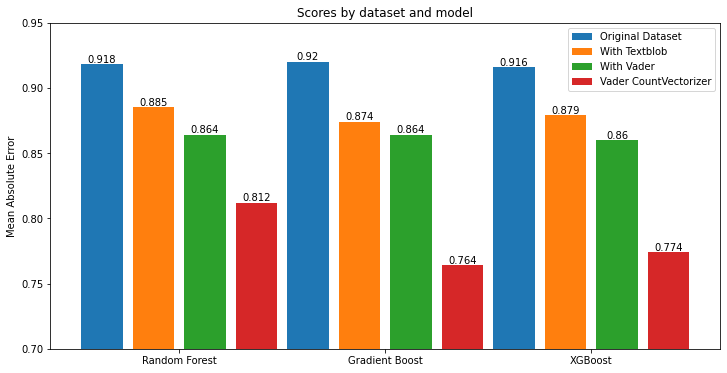

In [45]:
original = [0.918, 0.920, 0.916]
textblob = [0.885, 0.874, 0.879]
vadergraph = [0.864, 0.864, 0.860]
vadercountvectorizer = [0.812, 0.764, 0.774]



N = 3
ind = np.array((0,1,2))
width = 0.25
fig= plt.figure(figsize=(12,6))
rects1 = plt.bar(ind, original, 4/5*width, label='Original Dataset')
rects2 = plt.bar(ind + width, textblob, 4/5*width,
    label='With Textblob')
rects3 = plt.bar(ind + 2*width, vadergraph, 4/5*width,
    label='With Vader')
rects4 = plt.bar(ind + 3*width, vadercountvectorizer, 4/5*width,
    label='Vader CountVectorizer')



plt.ylabel('Mean Absolute Error')
plt.title('Scores by dataset and model')
plt.axis([-.25,3,0.7,0.95])
plt.xticks(ind + 1.5*width, ('Random Forest', 'Gradient Boost', 'XGBoost'))
plt.legend(loc='best')


def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        plt.text(rect.get_x()+rect.get_width()/2., 1*h, h,
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

plt.show()
fig.savefig('Hotel-Reviews/images/model-comparison.png')

In [ ]:
#Using a dictionary to find words

In [ ]:
negative_words = {}
for i in negative_reviews:
    try:
        for w in i.split():
            if w not in negative_words.keys():
                negative_words[w] = 0
            negative_words[w] +=1
    except AttributeError:
        continue
        

In [ ]:
top_list = sorted(negative_words.values())[::-1][:30]
for k,v in negative_words.items():
    if v in top_list:
        print(k)

In [ ]:
positive_words = {}
for i in positive_reviews:
    try:
        for w in i.split():
            if w not in positive_words.keys():
                positive_words[w] = 0
            positive_words[w] +=1
    except AttributeError:
        continue

In [ ]:
top_list = sorted(negative_words.values())[::-1][:30]
for k,v in negative_words.items():
    if v in top_list:
        print(k)

In [ ]:
#Testing if there was a difference between ratings from europeans and non-europeans

In [ ]:
import re

In [ ]:
europe = pd.read_html('https://en.wikipedia.org/wiki/Ethnic_groups_in_Europe')

In [ ]:
euro = list(europe[4]['Country']
for idx, i in enumerate(euro):
    if not i.isalpha():
        euro[idx] = i[:-3]
    if i =='United King':
        euro[idx] = 'United Kingdom'
euro[6] = 'Bosnia and Herzegovina'

In [ ]:
euro

In [ ]:
data['Reviewer_Nationality'].unique()

In [ ]:
#euro_or_no = list(data['Reviewer_Nationality'])
#for idx, i in enumerate(euro_or_no):
#    euro_or_no[idx] = i[1:-1]
for idx,i in enumerate(euro_or_no):

    if i in list(euro):
        euro_or_no[idx] = 'European'
    else:
        euro_or_no[idx] = 'Not European'


In [ ]:
euro_or_no

In [ ]:
data['Reviewer_Nationality'] = euro_or_no

In [ ]:
euros = data.copy()

In [ ]:
euros.drop(['Hotel_Address', 'Additional_Number_of_Scoring', 'Review_Date',
        'Hotel_Name',
       'Negative_Review', 
       'Total_Number_of_Reviews', 'Positive_Review',
       'Total_Number_of_Reviews_Reviewer_Has_Given', 'Tags',
       'days_since_review', 'lat', 'lng'], axis=1, inplace=True)

In [ ]:
euros.Reviewer_Nationality.unique()

In [ ]:
euros.groupby('Reviewer_Nationality').mean()

In [2]:
cleanest = pd.read_csv('cleanest.csv')

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
cleanest = pd.read_csv('cleanest.csv')

In [6]:
neg_content = cleanest['Neg_Review_Clean']
pos_content = cleanest['Pos_Review_Clean']

In [ ]:
word_tokenize(neg_content)

In [7]:
# try ngrams 2,2
count = CountVectorizer(max_features=1000, stop_words='english', ngram_range=(2,2))

In [8]:
fitted_neg = count.fit_transform(cleanest['Neg_Review_Clean'].values.astype('U')) 
fitted_pos = count.fit_transform(cleanest['Pos_Review_Clean'].values.astype('U'))

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_pos = tfidf.fit_transform(cleanest['Pos_Review_Clean'].values.astype('U'))


In [ ]:
tfidf_neg = tfidf.fit_transform(cleanest['Neg_Review_Clean'].values.astype('U'))

In [ ]:
tfidf_pos = tfidf_pos.toarray()

In [ ]:
tfidf_neg.toarray()

In [ ]:
from sklearn.decomposition import NMF
model = NMF(n_components=5, init='random', random_state=0)
W = model.fit_transform(fitted_neg)
H = model.components_

In [ ]:
from sklearn.decomposition import NMF
def fit_nmf(r):
    nmf = NMF(n_components=r)
    nmf.fit(fitted_neg)
    W = nmf.transform(fitted_neg)
    H = nmf.components_
    return nmf.reconstruction_err_


fit_nmf(10)
error = [fit_nmf(i) for i in range(1,11)]
plt.plot(range(1,11), error)
plt.xticks(range(1, 11))
plt.xlabel('r')
plt.ylabel('Reconstruction Error')

In [10]:
words = count.get_feature_names()

In [ ]:
words2 = count2.get_feature_names()

In [ ]:
def fit_nmf_pos(r):
    nmf = NMF(n_components=r)
    nmf.fit(fitted_pos)
    W = nmf.transform(fitted_pos)
    H = nmf.components_
    return nmf.reconstruction_err_

fit_nmf_pos(8)
error = [fit_nmf(i) for i in range(1,10)]
plt.plot(range(1,10), error)
plt.xticks(range(1, 10))
plt.xlabel('r')
plt.ylabel('Reconstruction Error')

In [ ]:
count3 = CountVectorizer(max_features=1000, stop_words='english', ngram_range=(3,3))

In [ ]:
words3 = count3.get_feature_names()

In [ ]:
fitted_neg3 = count3.fit_transform(neg_content.values.astype('U')) 
fitted_pos3 = count3.fit_transform(pos_content.values.astype('U'))

In [ ]:
from sklearn.decomposition import NMF
model = NMF(n_components=20, init='random', random_state=0)
W = model.fit_transform(fitted_neg3)
H = model.components_

In [ ]:
associated = []
for i in H:
    associated.append((np.argsort(i)[::-1][:10]))

In [ ]:
topics = []
for num, i in enumerate(associated):
    lst = []
    for idx in i:
        lst.append(words3[idx])
    topics.append(lst)
    print(f'topic{num+1} :', lst)

In [ ]:
from sklearn.decomposition import NMF
model = NMF(n_components=3, init='random', random_state=0)
W = model.fit_transform(fitted_neg)
H = model.components_

In [ ]:
associated = []
for i in H:
    associated.append((np.argsort(i)[::-1][:30]))

In [ ]:
topics = []
for num, i in enumerate(associated):
    lst = []
    for idx in i:
        lst.append(words[idx])
    topics.append(lst)
    print(f'topic{num+1} :', lst)

In [12]:

model = NMF(n_components=20, init='random', random_state=0)
W = model.fit_transform(fitted_neg)
H = model.components_

KeyboardInterrupt: 

In [ ]:
H.shape

In [ ]:
associated = []
for i in H:
    associated.append((np.argsort(i)[::-1][:10]))

In [ ]:
topics = []
for num, i in enumerate(associated):
    lst = []
    for idx in i:
        lst.append(words[idx])
    topics.append(lst)
    print(f'topic{num+1} :', lst)

In [13]:
from sklearn.decomposition import NMF

model = NMF(n_components=3, init='random', random_state=0)
W2 = model.fit_transform(fitted_neg)
H2 = model.components_

In [24]:
associated_pos = []
for i in H2:
    associated_pos.append((np.argsort(i)[::-1]))

In [25]:
topics_pos = []
for num, i in enumerate(associated_pos):
    lst = []
    for idx in i:
        lst.append(words[idx])
    topics_pos.append(lst)
    print(f'topic{num+1} :', lst)

topic1 : ['size bed', 'restaurant staff', 'restaurant hotel', 'room small', 'king size', 'room room', 'nice location', 'standard room', 'nice room', 'breakfast included', 'clean good', 'facility staff', 'location modern', 'quiet room', 'train station', 'metro line', 'bit small', 'nice modern', 'location minute', 'euston station', 'room ready', 'roof bar', 'bed pillow', 'excellent bed', 'nice spacious', 'restaurant bar', 'room comfortable', 'minute walk', 'fantastic breakfast', 'great restaurant', 'recommend hotel', 'room fantastic', 'reception helpful', 'free coffee', 'night stay', 'check staff', 'really helpful', 'quiet area', 'comfortable bathroom', 'hyde park', 'shopping centre', 'hotel breakfast', 'modern decor', 'quiet night', 'room spacious', 'room really', 'room great', 'pleasant helpful', 'breakfast wonderful', 'room staff', 'reasonable price', 'hotel excellent', 'shopping mall', 'restaurant close', 'restaurant cafe', 'lounge area', 'service friendly', 'helpful welcoming', 'roo

In [ ]:
from textblob import TextBlob

In [ ]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

data['Neg_Review_Clean'] = data['Negative_Review']

lem = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

filtered = []
for i in data['Neg_Review_Clean'][:2]:
    i = i.split()
    filtered_sentence = [lem.lemmatize(w) for w in i if w not in stop_words]
    filtered.append(' '.join(filtered_sentence))

In [ ]:
data['Neg_Review_Clean'][0]

In [ ]:
datafiltered[0]

In [16]:
#Word Clouds
from wordcloud import WordCloud
wc = WordCloud(background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)


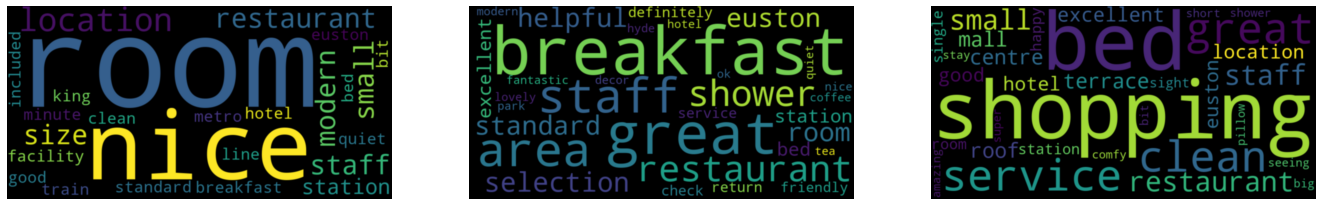

In [20]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [40, 10]

# Create subplots for each Topic
for index, topic in enumerate(topics_pos):
    wc = WordCloud(width = 1000, height = 500).generate(' '.join(topic))
    
    plt.subplot(2, 5, index+1)
    plt.imshow(wc, interpolation="quadric")
    plt.axis("off")
    #plt.title(hand_labels[index])
    
plt.show()

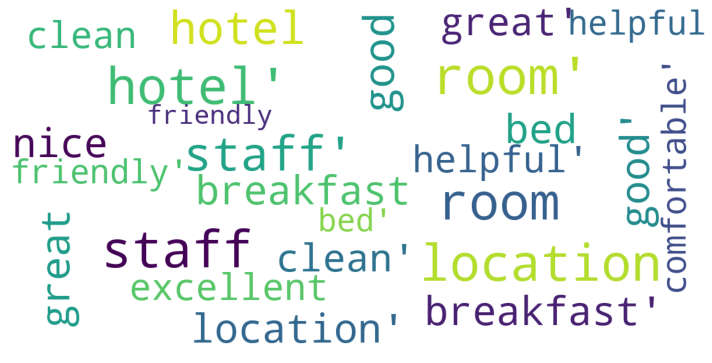

In [47]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 25,
        max_font_size = 30, 
        scale = 3,
    ).generate(str(data))

    fig = plt.figure(1, figsize = (10, 10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.tight_layout()
    plt.show()

    return fig
# print wordcloud
fig = show_wordcloud(topics_pos[0])
fig.savefig('Hotel-Reviews/images/topic1.jpg')


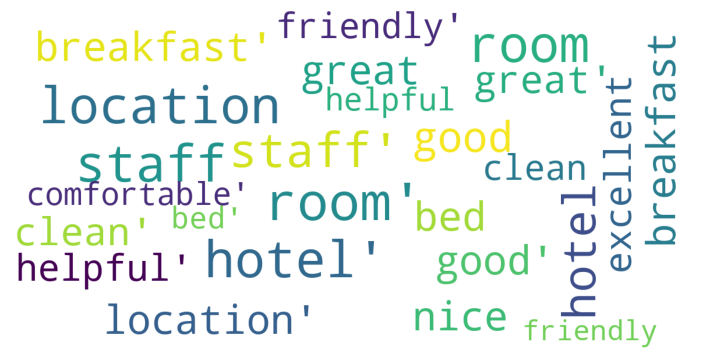

In [48]:
fig2 = show_wordcloud(topics_pos[1])
fig2.savefig('Hotel-Reviews/images/topic2.jpg')


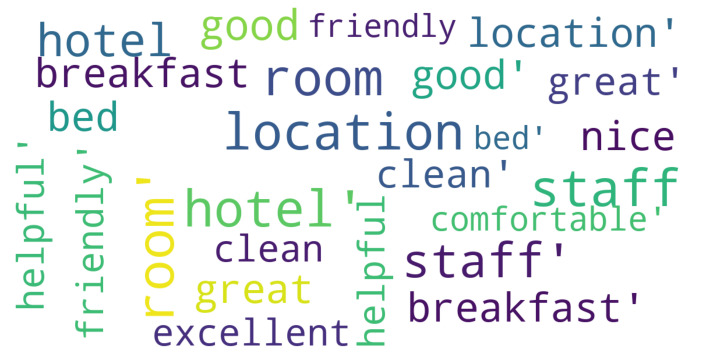

In [49]:
fig3 = show_wordcloud(topics_pos[2])
fig3.savefig('Hotel-Reviews/images/topic3.jpg')

In [ ]:
show_wordcloud(fitted_neg)

In [ ]:
# Checking monthly trend, consistent scoring
monthdf = data[['Review_Date','Average_Score','Reviewer_Score']]

In [ ]:
monthdf['Review_Date'] = pd.to_datetime(monthdf['Review_Date'])

In [ ]:
monthdf['Review_Date'] = monthdf['Review_Date'].apply(lambda x: x.strftime('%Y-%m'))

In [ ]:
monthdf['City'] = city

In [ ]:
monthdf

In [ ]:
monthdf = monthdf.groupby(['Review_Date', 'City']).agg({'Average_Score':'mean', 'Reviewer_Score':'mean'})

In [ ]:
monthdf.reset_index(inplace=True)

In [ ]:
monthdf.sort_values('City')

In [ ]:
#mapping
mapdf = data[['Hotel_Name', 'Average_Score', 'lat', 'lng']]
mapdf = mapdf.groupby(['Hotel_Name']).agg({'Average_Score':'mean', 'lat':'mean', 'lng':'mean'})
mapdf = mapdf.dropna()
mapdf.reset_index(inplace=True)

In [ ]:
mapdf['color'] = pd.cut(mapdf['Average_Score'], bins=[0,8.1,8.5,8.9,10], 
                              labels=['red', 'orange', 'blue', 'green'])

In [ ]:
import folium
m = folium.Map(location=[52.360576, 4.915968])

image_file='legend.png'

FloatImage(image_file,bottom=5,left=5).add_to(m)

for i in range(mapdf.shape[0]):
    folium.CircleMarker([mapdf['lat'][i],mapdf['lng'][i]], radius=2,tooltip=f'{mapdf["Hotel_Name"][i]} : {mapdf["Average_Score"][i]:0.2}', color=mapdf['color'][i]).add_to(m)
m

In [ ]:
from folium.plugins import FloatImage


import folium
b = folium.Map(location=[52.360576, 4.915968])
# convert to (n, 2) nd-array format for heatmap
import folium.plugins as plugins
lat = np.array(mapdf['lat'])
lng = np.array(mapdf['lng'])
coords = []
for i,j in zip(lat,lng):
    coords.append((i,j))
hotels = np.array(coords)


'''steps = 20
color_map=cm.linear.BuGrYlRd.scale(0,1).to_step(steps)

gradient_map=defaultdict(dict)
for i in range(steps):
    gradient_map[1/steps*i] = color_map.rgb_hex_str(1/steps*i)'''



image_file='legend.png'

FloatImage(image_file,bottom=5,left=5).add_to(b)

# plot heatmap
for i in range(mapdf.shape[0]):
    folium.CircleMarker([mapdf['lat'][i],mapdf['lng'][i]], radius=2, tooltip=f'{mapdf["Hotel_Name"][i]} : {mapdf["Average_Score"][i]:0.2}', color=mapdf['color'][i]).add_to(b)


b.add_children(plugins.HeatMap(hotels, radius=30))
b



In [ ]:
mapdata = np.array(mapdf[['lat', 'lng','Average_Score']])

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=10000, stop_words='english')
tfidf_pos = count.fit_transform(pos_content.values.astype('U'))
tfidf_neg = count.fit_transform(neg_content.values.astype('U'))

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

analyser = SentimentIntensityAnalyzer()

In [ ]:
a = analyser.lexicon.keys()
b = analyser.lexicon.values()

In [ ]:
hotel_lexicon = {k:v for k,v in zip(a,b)}

In [ ]:
hotel_lexicon['small']

In [ ]:
snt = analyser.polarity_scores('No Positive')

In [ ]:
snt['compound']

In [ ]:
data["Negative_Review"] = data["Negative_Review"].apply(lambda x: str(x).replace("No Negative", ""))
data["Positive_Review"] = data["Positive_Review"].apply(lambda x: str(x).replace("No Positive", ""))

In [ ]:
neg = data['Negative_Review']
neg_review_sentiment = []
for i in neg:
    snt = analyser.polarity_scores(i)
    neg_review_sentiment.append(snt['compound'])


In [ ]:
pos = data['Positive_Review']
pos_review_sentiment = []
for i in pos:
    snt = analyser.polarity_scores(i)
    pos_review_sentiment.append(snt['compound'])


In [ ]:
vader

In [ ]:
cleanest = pd.read_csv('cleanest.csv')

In [ ]:
cleanest["Neg_Review_Clean"] = cleanest["Neg_Review_Clean"].apply(lambda x: str(x).replace("No Negative", ""))
cleanest["Pos_Review_Clean"] = cleanest["Pos_Review_Clean"].apply(lambda x: str(x).replace("No Positive", ""))
                                                                  

In [ ]:
cleanest

In [ ]:
vader = cleanest.copy()

In [ ]:
#vader.drop(['neg_review_sentiment', 'pos_review_sentiment'], axis=1, inplace=True)

vader['pos_sent'] = pos_review_sentiment
vader['neg_sent'] = neg_review_sentiment

In [ ]:
vader.drop(['Unnamed: 0', 'Unnamed: 0.1','Neg_Review_Clean', 'Pos_Review_Clean'], axis=1, inplace=True)

In [ ]:
vader.to_csv('vader.csv')

In [ ]:
vader.drop('Additional_Number_of_Scoring', axis=1, inplace=True)

In [ ]:
vader[vader['pos_sent']<-0.5]

In [ ]:
vader[vader['neg_sent']>0]

In [ ]:
data['Positive_Review'][577]

In [ ]:
vader

In [ ]:
data['Hotel_Address'][455551]

In [ ]:
city = data['Hotel_Address']
for idx, i in enumerate(city):
    if 'Amsterdam' in i:
        city[idx] = 'Amsterdam'
    if 'Vienna' in i:
        city[idx] = 'Vienna'
    if 'Milan' in i:
        city[idx] = 'Milan'
    if 'Barcelona' in i:
        city[idx] = 'Barcelona'
    if 'Paris' in i:
        city[idx] = 'Paris'
    if 'London' in i:
        city[idx] = 'London'
        

In [ ]:
city = pd.Series(city)

In [ ]:
vader['City'] = city

In [ ]:
cities = pd.get_dummies(vader['City'])
vader = vader.join(cities)
vader.drop(['City'], axis=1, inplace=True)

In [ ]:
vader

In [ ]:
data.head()

In [ ]:
from sklearn.naive_bayes import GaussianNB 
NB = GaussianNB()
neg_pos = data['Reviewer_Score'] > 7.25
sentiment_predictor = NB.fit(tfidf_pos, neg_pos)
sentiment_predictor.

In [ ]:
plt.figure(figsize=(12,8))
plt.hist(data['Reviewer_Score'], bins = 40)
plt.xlabel('Reviewer Score')
plt.ylabel('Occurrences')
plt.title('Frequency Distribution of Reviewer Scores')

In [ ]:
data.drop('Additional_Number_of_Scoring', axis=1, inplace=True)


In [ ]:
data.drop(['lat', 'lng', 'Total_Number_of_Reviews', 'Total_Number_of_Reviews_Reviewer_Has_Given'], axis=1, inplace=True)
data.describe()

In [ ]:
data['Reviewer_Score'].std()

In [ ]:
data['Reviewer_Score'].mean()

In [ ]:
8.395-3*1.637

In [ ]:
a = data['Reviewer_Score']<3
a.sum()

In [ ]:
cleanest = pd.read_csv('cleanest.csv')

In [ ]:
cleanest["Negative_Review"] = cleanest["Negative_Review"].apply(lambda x: str(x).replace("No Negative", ""))
cleanest["Positive_Review"] = cleanest["Positive_Review"].apply(lambda x: str(x).replace("No Positive", ""))
cleanest["Neg_Review_Clean"] = cleanest["Neg_Review_Clean"].apply(lambda x: str(x).replace("No Negative", ""))
cleanest["Pos_Review_Clean"] = cleanest["Pos_Review_Clean"].apply(lambda x: str(x).replace("No Positive", ""))

In [ ]:
cleanest["Pos_Review_Clean"][3]

In [ ]:
spell = SpellChecker()
sp = []
for i in cleanest['Pos_Review_Clean']:
    misspelled = spell.unknown(word_tokenize(i))
    for w in misspelled:
        sp.append(w)

In [ ]:
sorted(set(sp))

In [ ]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from spellchecker import SpellChecker
from sklearn.feature_extraction.text import CountVectorizer
count = CountVectorizer(stop_words='english')

In [ ]:
cleanest['differential'] = cleanest['Reviewer_Score'] - data['Average_Score']

In [ ]:
neg_dict = {}
for idx, i in enumerate(cleanest['Neg_Review_Clean']):
    try:
        for w in word_tokenize(i):
            if w.isalpha():
                w=w.lower()
                if w not in neg_dict.keys():
                    neg_dict[w] = 0
                neg_dict[w] -=1
    except TypeError:
        continue

In [ ]:
sorted(neg_dict.values())

In [ ]:
pos_dict = {}
for i in cleanest['Pos_Review_Clean']:
    try:
        for w in word_tokenize(i):
            w=w.lower()
            if w.isalpha():
                if w not in pos_dict.keys():
                    pos_dict[w] = 0

                pos_dict[w]+=1
    except TypeError:
        continue            


In [ ]:
sorted(pos_dict.values())[::-1]

In [ ]:
len(pos_dict.keys())

In [ ]:
len(neg_dict.keys())

In [ ]:
merged_dict = neg_dict.copy()

for i in pos_dict.keys():
    if i not in merged_dict.keys():
        merged_dict[i]=0
    merged_dict[i] += pos_dict[i]

In [ ]:
top_neg = sorted(merged_dict.items(), key=(lambda item: item[1]))[:55]

In [ ]:
top_pos = sorted(merged_dict.items(), key=(lambda item: item[1]))[73480:]

In [ ]:
#top_pos[::-1]

In [ ]:
a = analyser.lexicon.keys()
b = analyser.lexicon.values()

In [ ]:
hotel_lexicon = {k:v for k,v in zip(a,b)}

In [ ]:
in_lexicon = []
for i in top_pos:
    if i[0] in hotel_lexicon.keys():
        in_lexicon.append((i[0], hotel_lexicon[i[0]]))
    else:
        in_lexicon.append(i)

In [ ]:
pos_in_lexicon = [i for i in in_lexicon if i[1]>4]

In [ ]:
nin_lexicon = []
for i in top_neg:
    if i[0] in hotel_lexicon.keys():
        nin_lexicon.append((i[0], hotel_lexicon[i[0]]))
    else:
        nin_lexicon.append(i)

In [ ]:
neg_in_lexicon = [i for i in nin_lexicon if i[1]<-4]

In [ ]:
neg_in_lexicon 

In [ ]:
w_pos_in_lexicon = [i[0] for i in pos_in_lexicon]
w_neg_in_lexicon = [i[0] for i in neg_in_lexicon]

In [ ]:
#w_neg_in_lexicon

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
#vader3
'''pos_words = {'large':1.5,
 'minute':1,
 'convenient':1.5,
 'walking':1,
 'near':1,
 'central':1,
 'view':1,
 'walk':1,
 'spacious':2,
 'modern':2,
 'everything':1,
 'quiet':1,
 'comfy':1,
 'close':1,
 'location':1.5}

neg_words = {
 'small': -2,
 'little':-2,
 'expensive': -2,
 'work':-1,
 'not':-1,
 'air':-0.5,
 'noise': -2,
 'told':-0.5,
 'bathroom':-1,
 'water':-1,
 'booking': -1,
 'hot':-1,
 'shower':-2,
 'cold': -3,
 'price':-1,
 'slow': -2,
 'booked':-1,
 'old':-1,
 'paid':-0.5,
 'toilet':-1,
 'tiny':-2,
 'working':-1}
'''

#vader4
pos_words = {'large':1.5,
 'minute':1,
 'convenient':1.5,
 'walking':1,
 'near':1,
 'central':1,
 'view':1,
 'walk':1,
 'spacious':2,
 'modern':2,
 'everything':1,
 'quiet':1,
 'comfy':1,
 'close':1,
 'location':1.5}

neg_words = {
 'i':-.05
 'small': -2,
 'little':-2,
 'expensive': -2,
 'work':-1,
 'not':-1,
 'air':-1,
 'noise': -2,
 'told':-0.5,
 'bathroom':-1,
 'water':-1,
 'booking': -1,
 'hot':-1,
 'shower':-2,
 'cold': -3,
 'price':-1,
 'slow': -2,
 'booked':-1,
 'old':-1,
 'paid':-0.5,
 'toilet':-1,
 'tiny':-2,
 'working':-1}
analyser = SentimentIntensityAnalyzer()

analyser.lexicon.update(pos_words)
analyser.lexicon.update(neg_words)

In [ ]:
vader = pd.read_csv('vader.csv')

In [ ]:
data["Negative_Review"] = data["Negative_Review"].apply(lambda x: str(x).replace("No Negative", ""))
data["Positive_Review"] = data["Positive_Review"].apply(lambda x: str(x).replace("No Positive", ""))

In [ ]:
pos = data['Positive_Review']
pos_review_sentiment = []
for i in pos:
    snt = analyser.polarity_scores(i)
    pos_review_sentiment.append(snt['compound'])


In [ ]:
neg = data['Negative_Review']
neg_review_sentiment = []
for i in neg:
    snt = analyser.polarity_scores(i)
    neg_review_sentiment.append(snt['compound'])

In [ ]:
vader3 = vader2.copy()
vader3['new_pos_sent'] = pos_review_sentiment
vader3['New_neg_sent'] = neg_review_sentiment


In [ ]:
vader3.to_csv('vader3.csv')

In [ ]:
vader2.head()

In [ ]:
vader2.to_csv('vader2.csv')

In [ ]:
vader2 = pd.read_csv('vader2.csv')

In [ ]:
vader2.drop(['pos_sent', 'neg_sent'],axis=1, inplace=True)

In [ ]:
#y = vader3.pop('Reviewer_Score')
#Xv2 = vader3
Xv2_train, Xv2_test, yv2_train, yv2_test = train_test_split(Xv,y, test_size=.2)

In [ ]:
rf = RandomForestRegressor(max_depth=20, max_features=15, min_samples_leaf=10,
                      n_estimators=500,)

In [ ]:
#0.8644864926810877 vader, vader2: 0.8652860490218461, v3: 0.8591603772526949

rf.fit(Xv_train, yv2_train)

yvadersearch = rf.predict(Xv2_test)
mean_absolute_error(yv2_test, yvadersearch)

In [ ]:
rf = RandomForestRegressor(max_depth=50, max_features=70, min_samples_leaf=30,
                      n_estimators=750,)

In [ ]:
rf.fit(Xv_train, yv_train)

yvadersearch = rf.predict(Xv_test)
mean_absolute_error(yv_test, yvadersearch)

In [ ]:
resid = (yvadersearch-yv_test)

In [ ]:
max(yv_test)

In [ ]:
difference

In [ ]:
print(f'{np.mean(difference)})
print(min(difference)) #max overguess
print(max(difference)) # max underguess

In [ ]:
plt.bar(yv_test,resid)

In [ ]:
len(edited_dict.items())

In [ ]:
sorted(edited_dict.items(), key=(lambda item: item[1]))

In [ ]:
sent_dict = {key:val for key, val in merged_dict.items() if key in edited_dict.keys()}

In [ ]:
sent_dict

In [2]:
lst = [('Location', 182356),
 ('Staff', 156235),
 ('Good', 91507),
 ('Friendly', 80715),
 ('Helpful', 71799),
 ('Excellent', 59915),
 ('Nice', 59561),
 ('Clean', 58436),
 ('Comfortable', 54418),
 ('Hotel', 49731)]
words = []
vals = []
for i in lst:
    words.append(i[0])
    vals.append(i[1])


In [3]:
pos_words = pd.DataFrame([words,vals])

In [4]:
pos_words=pos_words.T

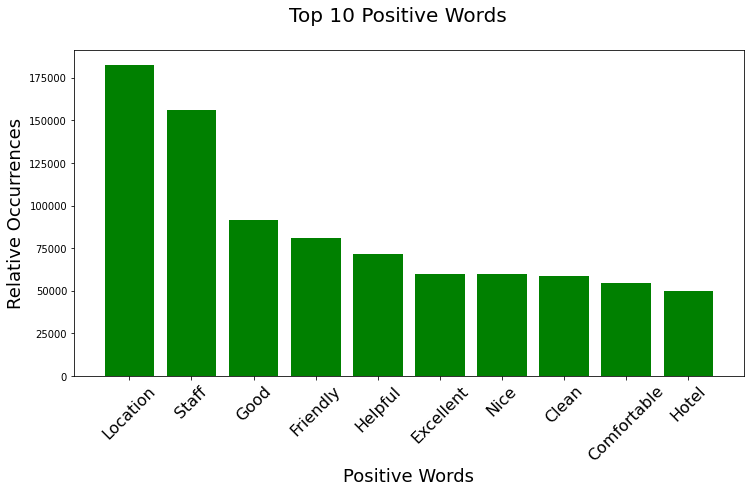

In [11]:
fig, ax = plt.subplots(figsize=(12,6))
ax.bar(pos_words[0], pos_words[1], color='green')
ax.xaxis.set_tick_params(labelsize=16, rotation=45, )
ax.set_xlabel('Positive Words', fontsize=18)
ax.set_ylabel('Relative Occurrences', fontsize=18)
fig.suptitle('Top 10 Positive Words', fontsize=20);
plt.savefig('Hotel-Reviews/images/poswords.jpg')

In [6]:
neglst = [ 
('I', 54831),
 ('Small', 38226),
 ('Nothing', 32126),
 ('Room', 29869),
 ('Bit', 23675),
 ('Could', 22721),
 ('Poor', 15300),
 ('Little', 15107),
 ('Expensive', 14225),
 ('Noisy', 12803)
]
words = []
vals = []
for i in neglst:
    words.append(i[0])
    vals.append(i[1])

In [7]:
neg_words = pd.DataFrame([words,vals])
neg_words=neg_words.T

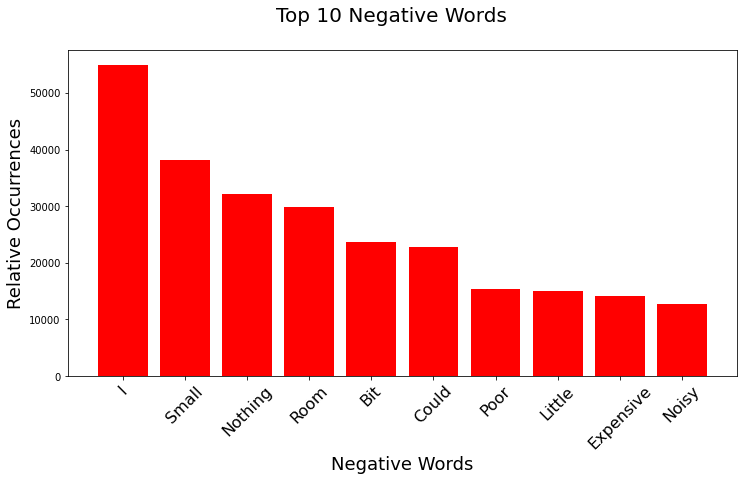

In [10]:
fig, ax = plt.subplots(figsize=(12,6))
ax.bar(neg_words[0], neg_words[1], color='red')
ax.xaxis.set_tick_params(labelsize=16, rotation=45)
ax.set_xlabel('Negative Words', fontsize=18)
ax.set_ylabel('Relative Occurrences', fontsize=18)
fig.suptitle('Top 10 Negative Words', fontsize=20);
plt.savefig('Hotel-Reviews/images/negwords.jpg')

In [ ]:
featurelist = [('fabulous', 0.29964397592170217), ('room', 0.30194291249199645), ('Review_Total_Positive_Word_Counts', 0.3052570176688559), ('view_neg', 0.3065943580036194), ('customer_neg', 0.309148504285848), ('like', 0.3097000750242623), ('cleaned_neg', 0.3138296421587767), ('far_neg', 0.31415213928598024), ('experience_neg', 0.3160898314851383), ('upgraded', 0.31808503933448273), ('uncomfortable_neg', 0.3181067243519525), ('amazing', 0.32032346693149794), ('positive', 0.3268533664683133), ('friendly_neg', 0.3279204781542303), ('star', 0.3316088215976614), ('money', 0.33323600792235114), ('furniture_neg', 0.33556941761333337), ('thing_neg', 0.3359991773269183), ('basic_neg', 0.3371390389734257), ('worth_neg', 0.34183704961622896), ('bad_neg', 0.35738071688622886), ('excellent', 0.3594808207557529), ('service', 0.359927338350747), ('good', 0.36450212979652796), ('value_neg', 0.36939321877731096), ('Average_Score', 0.37155553164158), ('maybe_neg', 0.3742655712045161), ('slightly_neg', 0.3756614262933333), ('problem_neg', 0.37852534112012903), ('negative_neg', 0.3795259726073531), ('liked_neg', 0.3798875420290196), ('loved', 0.38373564215679484), (' Leisure trip ', 0.3845988736897397), ('thing', 0.3854006269861976), ('tiny_neg', 0.3855309579764056), ('smell_neg', 0.39104875876111), ('comfort', 0.396663971459846), ('service_neg', 0.40567563202398277), ('poor_neg', 0.40716188873969195), ('location', 0.4366442383734017), ('exceptional', 0.44605379501967746), ('fantastic', 0.4506617635248613), ('manager_neg', 0.4539769613296106), ('dated_neg', 0.4552046506772193), ('little_neg', 0.4669997007938732), ('bed_neg', 0.48724146197141455), ('location_neg', 0.5196409792334291), ('terrible_neg', 0.5253355840173783), ('ok', 0.533507276280509), ('old_neg', 0.5588221246639997), ('rude_neg', 0.5628752955510673), ('bit_neg', 0.5665008095155175), ('overpriced_neg', 0.5972159823682486), ('staff', 0.6016395407762328), ('hotel_neg', 0.6126645258793607), ('clean_neg', 0.6272994880442819), ('rooms_neg', 0.6394214532205174), ('Review_Total_Negative_Word_Counts', 0.643662427137203), ('star_neg', 0.6624058946175011), ('money_neg', 0.6654582424585267), ('cleanliness', 0.702056108507394), ('perfect_neg', 0.7507870704583097), ('fault_neg', 0.7786412114249133), ('dirty_neg', 0.9736228654579733), ('staff_neg', 1.1175715739400547), ('new_pos_sent', 1.197688207777768), ('New_neg_sent', 1.3588873831895074), ('room_neg', 3.213848362698663)][::-1]

In [ ]:
featurelist

In [ ]:
#Best and Worst Reviews

In [ ]:
negdf = vader[(vader['neg_sent']<-.95) & (vader['pos_sent']<-.95)]
negdf

In [ ]:
for i in negdf.index:
    print(f' Negative Review {i}: {data.loc[i]['Negative_Review']}')
    print(f' Positive Review {i}: {data.loc[i]['Positive_Review']}')

In [ ]:
posdf = vader[(vader['neg_sent']>.99) & (vader['pos_sent']>.99)]

In [ ]:
for i in posdf.index:
    print(f' Negative Review {i}: {data.loc[i]['Negative_Review']}')
    print(f' Positive Review {i}: {data.loc[i]['Positive_Review']}')